In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


Dataset Class from CSV

In [122]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        numFeat = 6 #------------------------
        numOut = 3
        self.X = np.empty([numFeat,len(self.df)-numFeat-numOut],dtype=np.float32)
        self.Y = np.empty([numOut,len(self.df)-numFeat-numOut],dtype=np.float32)
        for i in range(self.Y.shape[1]):
            self.X[:,i] = np.asarray(self.df.iloc[i:i+numFeat]["TOTAL"])
            self.Y[:,i] = np.asarray(self.df.iloc[i+numFeat:i+numFeat+numOut]["TOTAL"])

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.Y.shape[1]
    
    def __getitem__(self,idx):
        return self.X[:,idx].T, self.Y[:,idx]

Initialize test and train dataloaders

In [123]:
#create data loaders
train_data = dataSetAll(1900,2013)
test_data = dataSetAll(2013,2100)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Create Neural Network Autoregression class

In [124]:
# create neural netowrk
class NeuralNetwork(nn.Module):
    def __init__(self):
        hidden = 400
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Create train and tet loops

In [125]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

Train the network

In [126]:
learning_rate = .000000001
batch_size = 64
epochs = 2000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss: 7512110.000000  [    0/  784]
Test Error:
Avg loss: 42814504.166667 

loss: 2764356.750000  [    0/  784]
Test Error:
Avg loss: 35197582.583333 

loss: 2312024.000000  [    0/  784]
Test Error:
Avg loss: 31408543.416667 

loss: 2085185.000000  [    0/  784]
Test Error:
Avg loss: 29193777.750000 

loss: 1950674.000000  [    0/  784]
Test Error:
Avg loss: 27708874.812500 

loss: 1859002.375000  [    0/  784]
Test Error:
Avg loss: 26603866.000000 

loss: 1789532.625000  [    0/  784]
Test Error:
Avg loss: 25695036.416667 

loss: 1732528.875000  [    0/  784]
Test Error:
Avg loss: 24900621.604167 

loss: 1683006.500000  [    0/  784]
Test Error:
Avg loss: 24185347.750000 

loss: 1638665.875000  [    0/  784]
Test Error:
Avg loss: 23533490.166667 

loss: 1599253.625000  [    0/  784]
Test Error:
Avg loss: 22926341.583333 

loss: 1563286.000000  [    0/  784]
Test Error:
Avg loss: 22349842.770833 

loss: 1529738.375000  [    0/  784]
Test Error:
Avg loss: 21800801.416667 

loss: 149828

Test on single input

[[ 5905.  9567. 11036. 11729. 11385. 11531.]]
[[11200.283  10833.878   9855.0205]]
[[12918.]
 [13777.]
 [16166.]]


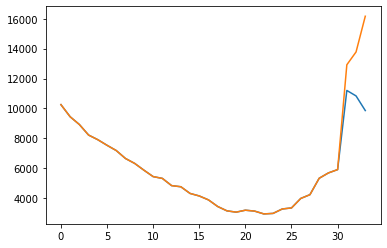

[[ 9567. 11036. 11729. 11385. 11531. 12918.]]
[[14071.869  15190.986  16023.2295]]
[[13777.]
 [16166.]
 [18504.]]


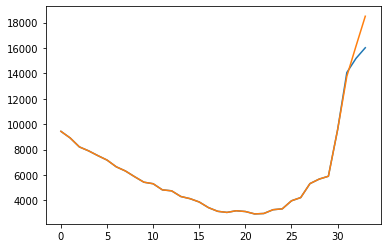

[[11036. 11729. 11385. 11531. 12918. 13777.]]
[[15184.7705 16721.697  18019.516 ]]
[[16166.]
 [18504.]
 [23068.]]


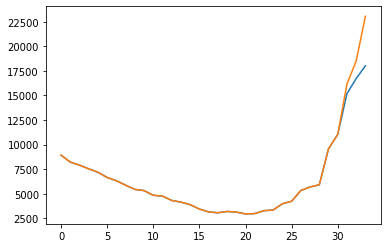

[[11729. 11385. 11531. 12918. 13777. 16166.]]
[[18387.594 20494.943 22177.828]]
[[18504.]
 [23068.]
 [29223.]]


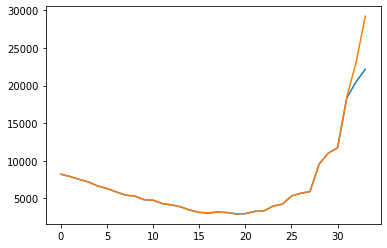

[[11385. 11531. 12918. 13777. 16166. 18504.]]
[[20768.55  22422.35  24027.926]]
[[23068.]
 [29223.]
 [37114.]]


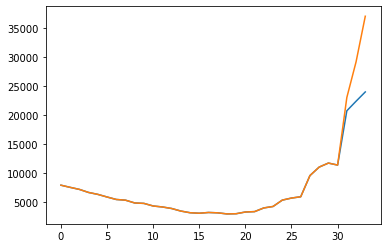

[[11531. 12918. 13777. 16166. 18504. 23068.]]
[[25432.648 26464.752 27175.643]]
[[29223.]
 [37114.]
 [42518.]]


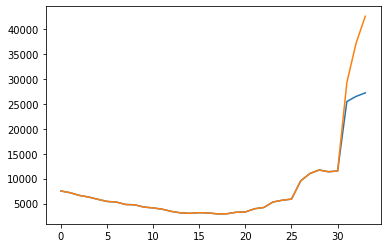

[[12918. 13777. 16166. 18504. 23068. 29223.]]
[[31375.16  31735.396 31816.395]]
[[37114.]
 [42518.]
 [38508.]]


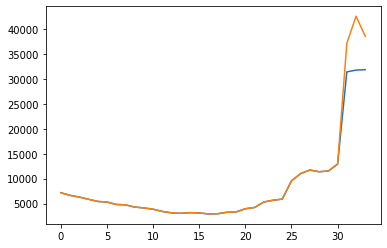

[[13777. 16166. 18504. 23068. 29223. 37114.]]
[[38580.348 38356.496 37374.12 ]]
[[42518.]
 [38508.]
 [35598.]]


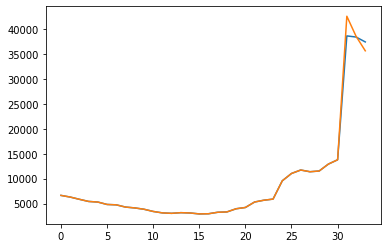

[[16166. 18504. 23068. 29223. 37114. 42518.]]
[[43186.543 42848.746 41803.008]]
[[38508.]
 [35598.]
 [34194.]]


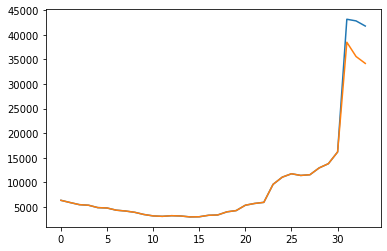

[[18504. 23068. 29223. 37114. 42518. 38508.]]
[[35271.09  32497.227 29546.852]]
[[35598.]
 [34194.]
 [32003.]]


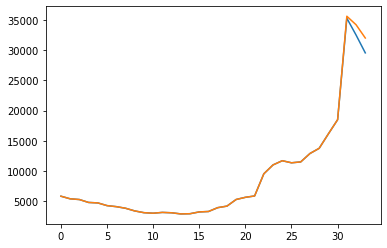

[[23068. 29223. 37114. 42518. 38508. 35598.]]
[[33002.36  30892.326 27797.666]]
[[34194.]
 [32003.]
 [29581.]]


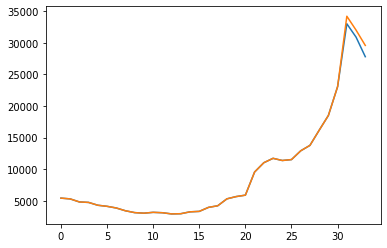

[[29223. 37114. 42518. 38508. 35598. 34194.]]
[[32424.672 30325.422 28767.207]]
[[32003.]
 [29581.]
 [26994.]]


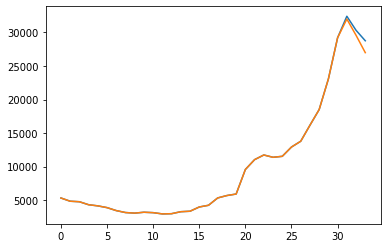

[[37114. 42518. 38508. 35598. 34194. 32003.]]
[[29338.854 28518.502 27886.338]]
[[29581.]
 [26994.]
 [24293.]]


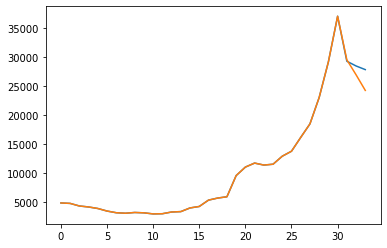

[[42518. 38508. 35598. 34194. 32003. 29581.]]
[[28581.14  27800.58  27349.357]]
[[26994.]
 [24293.]
 [22294.]]


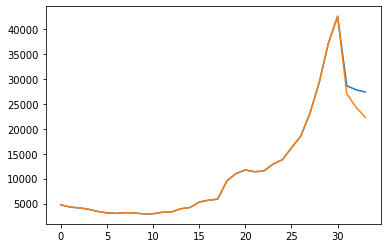

[[38508. 35598. 34194. 32003. 29581. 26994.]]
[[25279.898 24108.064 23733.234]]
[[24293.]
 [22294.]
 [20420.]]


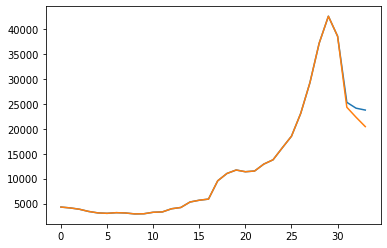

[[35598. 34194. 32003. 29581. 26994. 24293.]]
[[22156.934 20903.479 20226.479]]
[[22294.]
 [20420.]
 [19845.]]


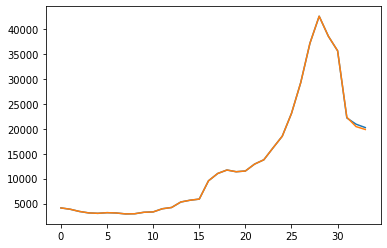

[[34194. 32003. 29581. 26994. 24293. 22294.]]
[[20669.82  20033.516 19736.562]]
[[20420.]
 [19845.]
 [18419.]]


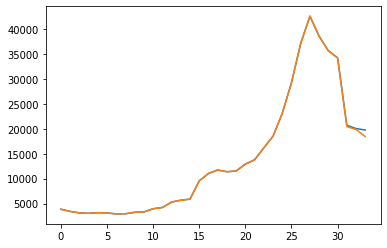

[[32003. 29581. 26994. 24293. 22294. 20420.]]
[[19253.07  18920.977 18633.191]]
[[19845.]
 [18419.]
 [16980.]]


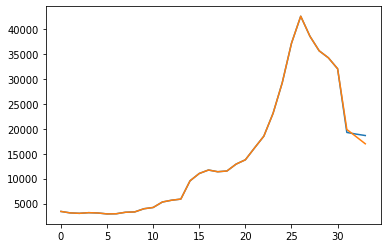

[[29581. 26994. 24293. 22294. 20420. 19845.]]
[[19259.322 19417.861 19140.398]]
[[18419.]
 [16980.]
 [15125.]]


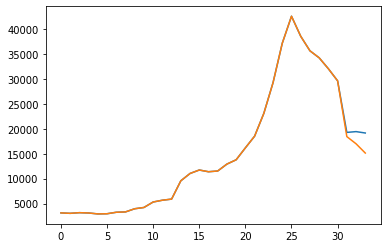

[[26994. 24293. 22294. 20420. 19845. 18419.]]
[[18025.652 17885.807 17630.041]]
[[16980.]
 [15125.]
 [14743.]]


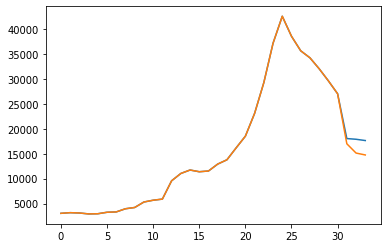

In [127]:
with torch.no_grad():
    model.eval()
    numOut = 2
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    for i in range(90,110):
        feat = test_data[i:i+1][0].numpy()
        pred = model(test_data[i:i+1][0]).numpy()
        act = test_data[i:i+1][1].numpy()
        full_back = data[i-30:i+1]
        print(feat)
        print(pred)
        print(act)
        # plt.plot(full_back)
        plt.plot(np.append(full_back,pred))
        plt.plot(np.append(full_back,act))
        plt.show()
